## Analysis of acoustic signals with giotto-time

*Data:* Acoustic impulse responses come from the simulated and measured impulse responses used in the following publication:
H. P. Tukuljac, V. Pulkki, H. Gamper, K. Godin, I. J. Tashev and N. Raghuvanshi, "A Sparsity Measure for Echo Density Growth in General Environments," ICASSP 2019 - 2019 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), Brighton, United Kingdom, 2019, pp. 1-5.
[paper](http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8682878&isnumber=8682151) and [code](https://github.com/microsoft/EchoDensity/)

*Task:* Recognize the type of acoustic space from its impulse response. There are three types of acoustic space that we can distinguish: parallel walls, room without and room with a ceiling.

*More information:* For more information about acoustics and acoustic data processing, please read: Helena Peic Tukuljac, “Sparse and parametric modeling with applications to acoustics and audio,” Lausanne, 2020, PhD Thesis, EPFL. [thesis](https://infoscience.epfl.ch/record/273930?ln=en)

### The task: Detection of the type of the acoustic environment

An acoustic impulse response (AIR) is a response of a certain environment to a Dirac sound as the input signal. AIR consists out of direct sound and numerous echoes that reach the sensor when the sound reflects on the walls. Reflections of walls are modeled with a so-called *image-source model*, which are located at the mirrored positions of the real source against the wall. Higher order virutal sources are determined recursively. Each image-source models the propagation delay of the arrival of an echo.

Here we see the real source and its image sources for an example of one wall and a 2D case with 4 walls. Sound travels at speed $c\approx340\frac{m}{s}$ and depending on the position of the image source, the corresponding echo has a certain delay. We will be interested in characterizing the evolution of the density of early reflections. Late reflections are usually characterized as attenuated Gaussian noise.

<img src="data/figures_blog/true_and_virtual_source.PNG" width=300><img src="data/figures_blog/image_source.PNG" width=300><img src="data/figures_blog/air.png" width=400>

In this demo, the task is to detect the type of the acoustic environment based on the distribution of echoes over time. We will be able to distinguish the following 4 situations in a _domino box_ (sliding lid) scenario: closed, almost closed, almost open and open.

<img src="data/figures_blog/sliding_lid.PNG" width=600>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import os

from collections import defaultdict

In [2]:
from gtime.custom.sorted_density import SortedDensity
from gtime.custom.crest_factor_detrending import CrestFactorDetrending
from src.helpers import remove_direct_sound, curve_fitting_echo_density

In [3]:
with h5py.File(os.path.join('data', 'acoustic_responses.h5'), 'r') as hf:
    dataset_simulation_sliding_lid = list(hf['dataset_simulation_sliding_lid'])
    Fs = list(hf['Fs'])[0]
labels = ['closed', 'almost_closed', 'almost_open', 'open']

In [4]:
data = defaultdict()
for i in range(len(labels)):
    data[labels[i]] = dataset_simulation_sliding_lid[i]
time_index = pd.timedelta_range(start=pd.Timedelta(days=0), freq=str(round(1000/Fs, 5)) + 'ms',
                                periods=len(dataset_simulation_sliding_lid[0]))
data_simulation_sliding_lid = pd.DataFrame(data = data, index = time_index)
data_simulation_sliding_lid.head()

,closed,almost_closed,almost_open,open
00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
00:00:00.000170,4.443116e-07,4.372601e-07,4.443116e-07,4.456350e-07
00:00:00.000340,1.300656e-05,1.283440e-05,1.300656e-05,1.303693e-05
00:00:00.000510,4.364509e-05,4.311583e-05,4.364509e-05,4.377377e-05
00:00:00.000680,1.987153e-05,1.957845e-05,1.987153e-05,1.991281e-05


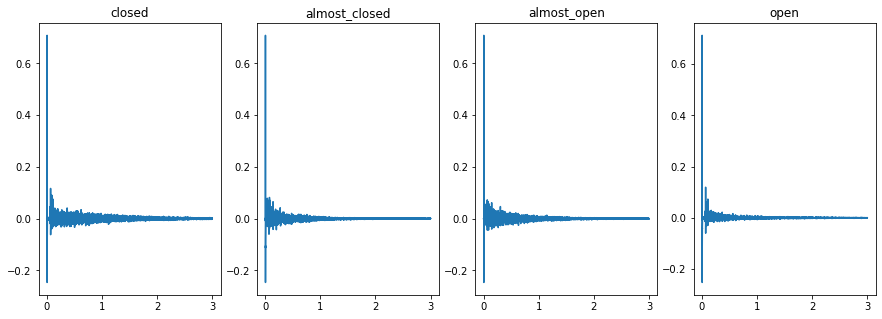

In [5]:
t = np.array(range(data_simulation_sliding_lid.shape[0]))/Fs
fig, ax = plt.subplots(1,4,figsize=(15,5))
for i in range(len(labels)):
    ax[i].plot(t, data_simulation_sliding_lid[labels[i]])
    ax[i].set_title(labels[i])

### Data preprocessing pipeline

Since the simulated and measured impulse responses contain a lot of noise - simulated responses are bandimited and measured reponses suffer from white noise and other types of acoustical effects, such as scattering, we need to preprocess AIRs $h[n]$ before fitting any type of curve. There are multiple preprocessing steps:
* direct path removal (since we want to characterize only the distribution of the echoes)
* crest factor detrending (since we do not want to have an assumption of the exponential decay of the energy)
* sorted density feature (since we want to be invariant to the effects of noise or bandlimited measurements)

In [6]:
# ws stands for window size
ws_detrending = int(0.025*Fs)     # 25ms
ws_sorted_density = int(0.2*Fs)   # 200ms
signal_length = 1
gaussian_sd = 0.18

(1) The *direct path removal* is perceptually motivated and it just removes the $\pm5ms$ around the highest peak, since the sounds that are less than $10ms$ apart get perceptually merged. This enables us to proceed with the characterization of the early reflections.

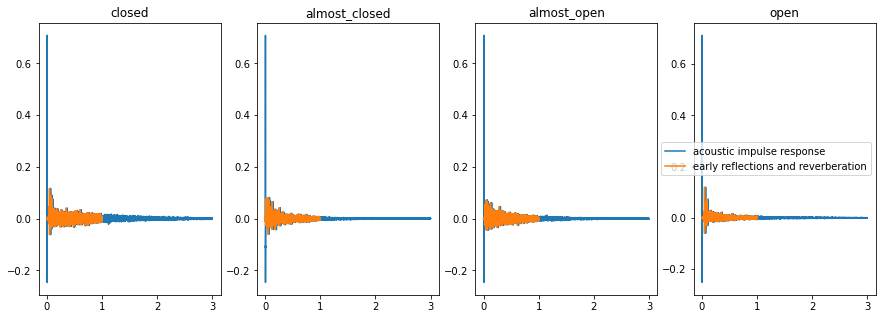

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
data_dir = defaultdict()
fig, ax = plt.subplots(1,4,figsize=(15,5))
for i in range(len(labels)):
    signal = data_simulation_sliding_lid[labels[i]]
    ax[i].plot(t[:len(signal)], signal, label='acoustic impulse response')
    data_dir[labels[i]] = remove_direct_sound(signal, Fs, signal_length)
    ax[i].plot(t[:len(data_dir[labels[i]])], data_dir[labels[i]], label='early reflections and reverberation')
    ax[i].set_title(labels[i])
plt.legend()

(2) The *crest factor detrending* was built from the basis of the [crest factor](https://en.wikipedia.org/wiki/Crest_factor), which is a ratio of the value of the current sample and its surrounding. This ensures that the number of density estimates are not biased by the overall energy envelope of the response. We want to potentially remove the trend from the data without close inspection of the data.

We normalize each sample value with the local mean of surrounding samples weighted with a Tukey window $w$ of length $N$:
$$\tilde{h}[n] = \frac{h[n]}{\sum_{i=n-N/2}^{n+N/2} h[n]\ w[n] }$$

The width of the window defines the temporal locality for normalization. We use $20ms$ window size with $5ms$ tapering parts, which are motivated by acoustical perceptual models. Input impulse response (left) is converted to an echogram (middle). Local energy normalization factors out the energy decay envelope (right).

CrestFactorDetrending(is_causal=False, window_size=147)


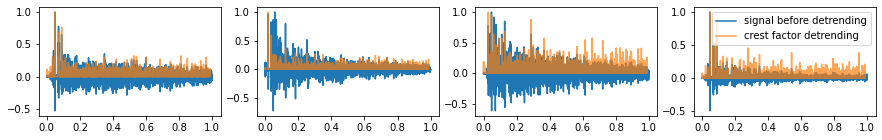

In [8]:
detrending_feature = CrestFactorDetrending(window_size=ws_detrending, is_causal = False)
print(detrending_feature)
data_dtr = defaultdict()
fig, ax = plt.subplots(1,4,figsize=(15,2))
for i in range(len(labels)):
    ax[i].plot(t[:len(data_dir[labels[i]])], data_dir[labels[i]]/np.max(np.abs(data_dir[labels[i]])), alpha=1, label='signal before detrending')
    data_dtr[labels[i]] = detrending_feature.fit_transform(pd.DataFrame(data_dir[labels[i]]))
    ax[i].plot(t[:len(data_dtr[labels[i]])], data_dtr[labels[i]]/np.max(np.abs(data_dtr[labels[i]])), alpha=0.7, 
               label='crest factor detrending')
plt.legend()

(3) The *sorted density* was built from the insentives of the center of mass of a sorted sequence. It shows among what part of samples within an observed window is most of the energy concentrated on.

In order to have a measure of the distribution of the energy over an observation window, we couple the sorting of the samples in the window of length $M$, $s = \textrm{sort}(\tilde{h})$ with the computation of the first moment (the center of mass):  
$$\mathcal{D}[s] \equiv \frac{1}{M}\frac{\sum_{i=1}^M i\ s[i]}{\sum_{i=1}^M s[i]}$$
where $M$ is the number of samples in the observed window.
The sorted density is a unitless measure with values ranging between 0 and 0.5 corresponding respectively to minimal echo density when $s$ contains a single non-zero sample, to maximum when all values are non-zero and equal. We normalize it with the sorted density measure of the Gaussian noise $\mathcal{D}[g]=0.18$:
$$N'_{sd}(t) = \frac{\mathcal{D}[ \tilde{e}\left(t\in(t-0.5T_l,t+0.5T_l\right) ]}{\mathcal{D}[g]}.$$
For this acoustic application the size of the observation window $T_l$ was $200ms$, but this can be changed and readjusted for the application at hand.

We need the Gaussian measure of detrended sorted density, since the reverberation of the room has close to Gaussian behavior. This constant will be used for the normalization before the curve fitting.

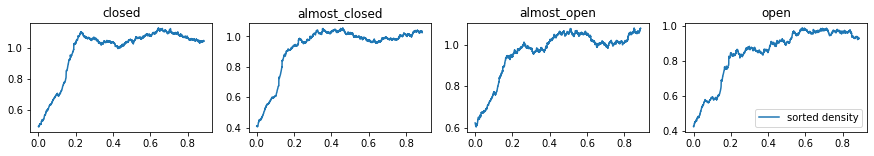

In [9]:
density_feature = SortedDensity(window_size=ws_sorted_density, is_causal = False)
data_srt = defaultdict()
fig, ax = plt.subplots(1,4,figsize=(15,2))
for i in range(len(labels)):
    data_srt[labels[i]] = density_feature.fit_transform(pd.DataFrame(data_dtr[labels[i]])).to_numpy()
    data_srt[labels[i]] = data_srt[labels[i]]/gaussian_sd
    ax[i].plot(t[:len(data_srt[labels[i]])], data_srt[labels[i]], label = 'sorted density')
    ax[i].set_title(labels[i])
plt.legend()

### Theoretically based curve fitting for parameter extraction

Here we observe what happens to the distribution of the image sources in the 3 target types of space. We are interested in the global trend of the acoustic echo build-up between moment $t$ and $t + \Delta t$. Assuming that we are dealing with an omnidirectional source, we have the followiing echo density trends:

<img src="data/figures_blog/echo_density_trends.PNG" width=500>

Since the general trend can be written as $Ct^n$, $n \in \{0,1,2\}$ all this will be modelled with a parametrized curve fitting.

If we use $\tau_{\textrm{m}}$ to denote the mixing time, which is the point where the exponential and the constant behaviour meet, we design the following parametric curve:
$$
\begin{split}
N'(t; N'_0, \alpha, n, \tau_{\textrm{m}}) = 
\begin{cases}
N'_0 + \alpha t^n, t<\tau_{\textrm{m}} \\
\hfill N'_\infty, t\geq\tau_{\textrm{m}}
\end{cases}
\end{split},
\label{eq:TheModel}
$$

$$
W(t;\tau_{\textrm{m}},\sigma) = \frac{1}{2}\Big( 1 - \tanh\Big(\frac{t - \tau_{\textrm{m}}}{\sigma}\Big)\Big).
$$

The parameter $\sigma$ controls width of the cross-fade, which we set to $\sigma=20~\textrm{ms}$. The resulting smoothed parametric model is:
$$
\begin{aligned}
\log(N'(t; \alpha, n, \tau_{\textrm{m}}) - N'_0) = W\cdot(\log\alpha + n \log t) + \\ (1 - W) \cdot \log (N'_\infty - N'_0) .
\end{aligned}
\label{eq:ModelFitting}
$$

<img src="data/figures_blog/model.PNG" width=300>

For the task at hand, we will be focusing on retrieving the correct parameter $n$. For cases of interest we have:

<img src="data/figures_blog/echo_density_trends_examples.PNG" width=500>

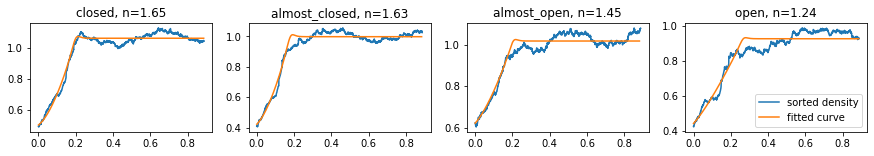

In [10]:
fig, ax = plt.subplots(1,4,figsize=(15,2))
for i in range(len(labels)):
    n, curve = curve_fitting_echo_density(data_srt[labels[i]], Fs)
    ax[i].plot(t[:len(data_srt[labels[i]])], data_srt[labels[i]], label = 'sorted density')
    ax[i].plot(t[:len(curve)], curve, label = 'fitted curve')
    ax[i].set_title(labels[i] + ', n=' + '{0:.2f}'.format(n))
plt.legend()